# Генеративная модель на основе гауссовых смесей

Гауссовы смеси — естественное математическое обобщение алгоритма `K-means`. По сути, подход ищет не просто какие-то кучки вокруг формирующихся центроидов, а некоторую смесь многомерных нормальных распределений (по сути — тоже кучки вокруг средних со своими дисперсиями). Так как такой подход оценивает плотности распределений, то он часто используется в задачах KDE (kernel density estimation). В том числе, он может быть применен к задаче генерации: если есть плотность распределения, то можно семплировать и получать новые объекты. Давайте посмотрим на простейший пример решения такой задачи.

Работать будем опять-таки с `MNIST`. Так как модель оказывается крайне тяжеловесной, будем использовать «простой» набор данных. Визуализируем элементы этого набора данных (для наглядности)

In [2]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()
digits.data.shape

(1797, 64)

In [3]:
len(digits.target)

1797

In [4]:
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

In [5]:
digits.images.shape

(1797, 8, 8)

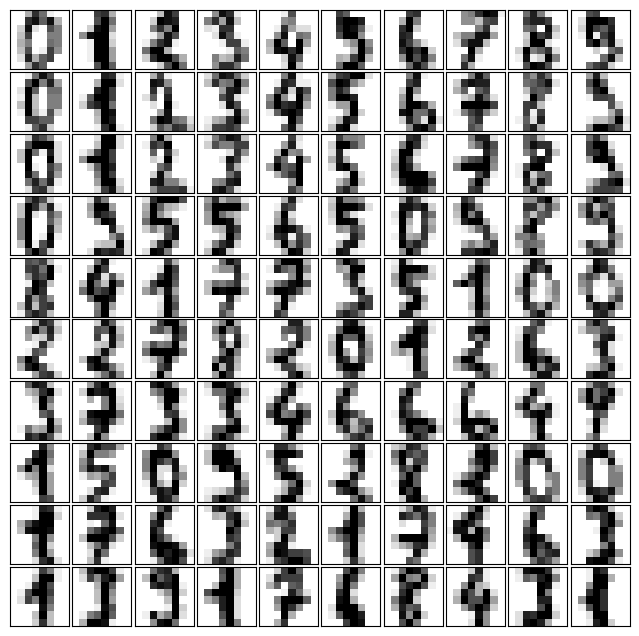

In [6]:
fig, ax = plt.subplots(10, 10, figsize=(8, 8), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
for i, axi in enumerate(ax.flat):
    im = axi.imshow(digits.data[i].reshape(8,8), cmap='binary')
    im.set_clim(0, 16)

Для того, чтобы обучение проходило быстрее имеет смысл снизить размерность пространства признаков. Произведите преобразования для всего набора данных помощи <code>PCA(n_components=0.99, svd_solver=='full')</code>.


In [7]:
from sklearn.decomposition import PCA

In [8]:
pca = PCA(n_components=0.99, svd_solver='full').fit(digits.data)

In [9]:
len(pca.components_)

41

In [10]:
import numpy as np

In [11]:
np.sum(pca.explained_variance_ratio_)

0.9901018242795545

Введите число полученных ГК

In [12]:
data = pca.transform(digits.data)

In [13]:
data.shape

(1797, 41)

In [14]:
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

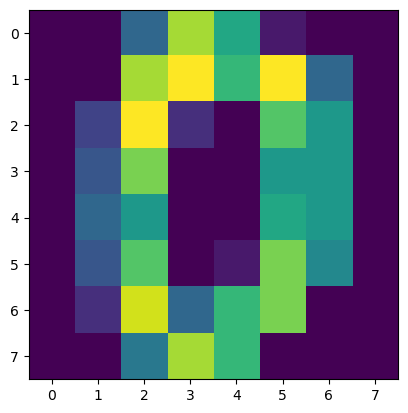

In [15]:
plt.imshow(digits.data[0].reshape(8, 8))

In [16]:
pca.inverse_transform(data[0]).reshape(8, 8)

array([[ 6.19092706e-16, -4.77529285e-02,  5.33644485e+00,
         1.28633144e+01,  9.10263269e+00,  1.00399309e+00,
        -1.02651160e-01,  4.02538117e-01],
       [-1.39200356e-02, -3.23798593e-01,  1.29342072e+01,
         1.50070947e+01,  9.97575274e+00,  1.49558145e+01,
         5.00074600e+00,  7.06705434e-01],
       [-9.34575502e-04,  3.30397156e+00,  1.50030566e+01,
         1.96787999e+00,  2.83741472e-02,  1.10381582e+01,
         7.87037486e+00,  3.64507869e-01],
       [-2.11648154e-03,  3.76731045e+00,  1.20210056e+01,
         2.24333327e-02, -6.34131390e-02,  8.04194790e+00,
         7.89500066e+00,  1.28380702e-02],
       [ 2.74081381e-16,  4.92609078e+00,  8.05443727e+00,
        -5.11598021e-02,  8.98009906e-02,  8.91342615e+00,
         8.23850093e+00,  8.96682784e-17],
       [ 1.29092822e-02,  4.23466575e+00,  1.09583066e+01,
         3.61733612e-02,  8.33684673e-01,  1.20903529e+01,
         6.64116762e+00,  3.93742152e-02],
       [ 3.18570165e-02,  1.504405

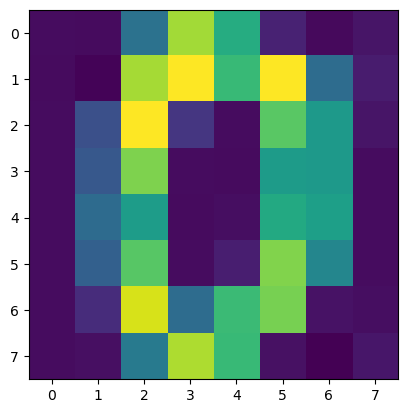

In [17]:
plt.imshow(pca.inverse_transform(data[0]).reshape(8, 8))

Обучим интересующую нас модель, подобрав гиперпараметр, отвечающий за число используемых компонент, минимизируя <a href="https://ru.wikipedia.org/wiki/Информационный_критерий_Акаике">информационный критерий Акаике</a>.

Для значений параметра <code>n_components</code> в диапазоне $[50,250)$ с шагом $10$ обучите модели <a href="https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html"><code>GaussianMixture</code></a> с параметрами, указанными в вашем задании. При помоши метода <code>.aic()</code> вычислите значение критерия каждой модели.

Введите значение <code>n_components</code> модели с наименьшим значением критерия Акаике.




In [18]:
import numpy as np

In [19]:
n_comps = np.arange(50, 250, 10)

In [20]:
from sklearn.mixture import GaussianMixture

In [21]:
nc_final = 0
min_aic = 10000000
for n_c in n_comps:
    gm = GaussianMixture(n_components=n_c, covariance_type='full', random_state=33).fit(data)
    print('N_components = {}, aic = {}'.format(n_c, gm.aic(data)))
    if min_aic > gm.aic(data):
        min_aic = gm.aic(data)
        nc_final = n_c

N_components = 50, aic = 163543.51396249596
N_components = 60, aic = 102110.02410401664
N_components = 70, aic = 38612.5982867025
N_components = 80, aic = -11672.460443175805
N_components = 90, aic = -68221.51384105277
N_components = 100, aic = -105025.53071519721
N_components = 110, aic = -133241.67228422326
N_components = 120, aic = -151955.25939232454
N_components = 130, aic = -173804.7649108934
N_components = 140, aic = -182913.97418394533
N_components = 150, aic = -185733.49987184198
N_components = 160, aic = -189325.89170862827
N_components = 170, aic = -185771.55987434048
N_components = 180, aic = -188835.4276676856
N_components = 190, aic = -189685.64021129627
N_components = 200, aic = -190504.401399001
N_components = 210, aic = -184785.53462247737
N_components = 220, aic = -182527.80379762105
N_components = 230, aic = -173005.8923528078
N_components = 240, aic = -163167.54304085986


In [22]:
nc_final

200

Обучите финальную модель на подобранном гиперпараметре. Проверьте, что обучение сошлось (поле <code>.converged_</code> модели).

In [23]:
gm = GaussianMixture(n_components=180, covariance_type='full', random_state=41).fit(data)

In [24]:
gm.aic(data)

-185865.19400245667

In [25]:
gm.converged_

True

При помощи метода <code>.sample()</code> сгенерируйте $100$ новых объектов.

Введите выборочное среднее коориднаты с индексом $0$ сгенерированных объектов.

In [26]:
np.mean(gm.sample(100)[0][0])

-0.9539804097453344

In [27]:
gm.sample(100)

(array([[ 10.58917593, -21.71599342,  14.04176934, ...,   1.78202953,
           0.601021  ,  -0.31011041],
        [ -4.24435786, -17.6266525 ,   9.81349692, ...,  -1.08657896,
           3.13713127,  -3.6546839 ],
        [-14.68170077, -10.85199567,  25.93001786, ...,   0.74887735,
          -0.49777326,   0.37895592],
        ...,
        [  8.26258082,  -8.75605982,   0.86948315, ...,   0.14482912,
           0.25955431,   1.19608691],
        [ -8.76159956,  -9.54853793,  10.37788862, ...,  -0.6186337 ,
           0.91709176,  -0.72772546],
        [  0.84978092,  -2.24862256,   2.38355911, ...,  -0.32933364,
           0.66644591,  -0.81619893]]),
 array([  2,   7,   8,   8,   8,   9,  16,  18,  21,  27,  29,  31,  33,
         34,  34,  34,  34,  36,  37,  37,  38,  41,  46,  46,  47,  50,
         51,  51,  52,  53,  57,  58,  58,  58,  60,  60,  61,  61,  62,
         63,  70,  73,  74,  77,  78,  79,  82,  83,  86,  86,  87,  87,
         89,  91,  92,  92,  95,  96,  96, 10

При помоши метода <code>.inverse_transform()</code> класса <code>PCA</code> верните сгенерированные объекты в пространство исходных признаков.

In [28]:
samples = gm.sample(100)

In [29]:
np.mean(samples[0])

0.027537128024708025

In [30]:
np.mean(samples[0][:, 0])

1.1744655693917065

In [31]:
np.mean(samples[0][0])

-0.9539804097453344

In [32]:
samples[0]

array([[ 10.58917593, -21.71599342,  14.04176934, ...,   1.78202953,
          0.601021  ,  -0.31011041],
       [ -4.24435786, -17.6266525 ,   9.81349692, ...,  -1.08657896,
          3.13713127,  -3.6546839 ],
       [-14.68170077, -10.85199567,  25.93001786, ...,   0.74887735,
         -0.49777326,   0.37895592],
       ...,
       [  8.26258082,  -8.75605982,   0.86948315, ...,   0.14482912,
          0.25955431,   1.19608691],
       [ -8.76159956,  -9.54853793,  10.37788862, ...,  -0.6186337 ,
          0.91709176,  -0.72772546],
       [  0.84978092,  -2.24862256,   2.38355911, ...,  -0.32933364,
          0.66644591,  -0.81619893]])

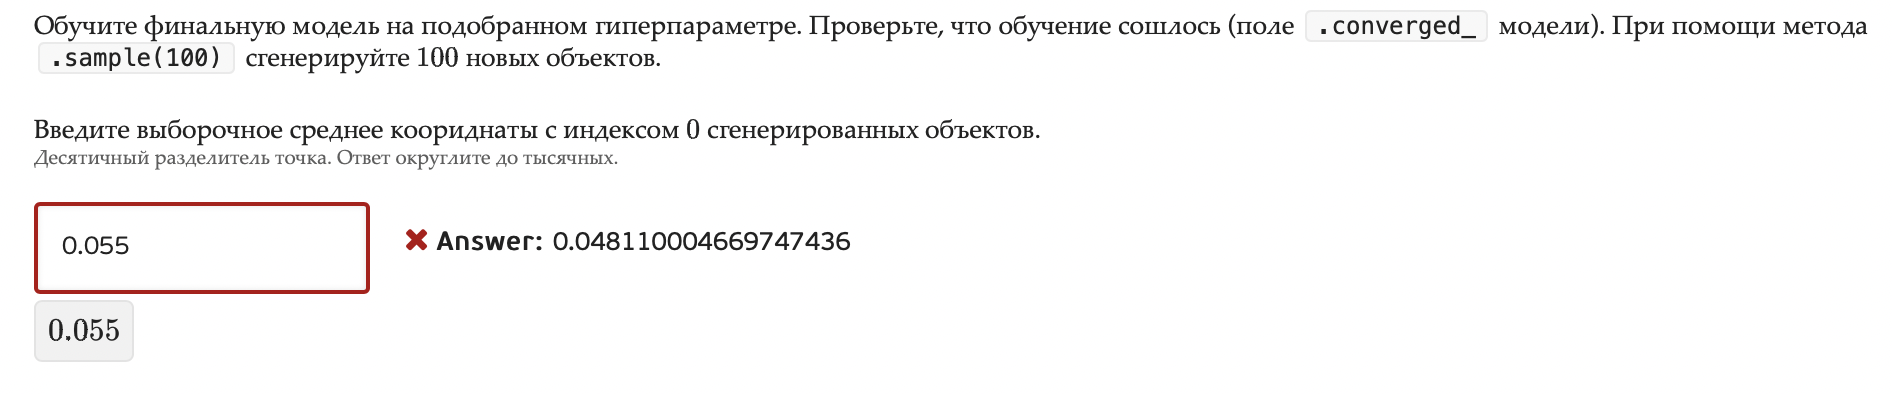

In [33]:
len(samples[0][17])

41

In [34]:
pca.inverse_transform(samples[0][17]).reshape(8, 8)

array([[-2.01426993e-17,  3.08194553e-01,  8.11148999e-02,
         5.84264723e+00,  1.48206618e+01,  1.39549519e+00,
         9.74191793e-01, -3.85036894e-01],
       [ 1.10137145e-02,  2.17771155e-01,  3.60280270e-01,
         1.37990072e+01,  9.54372116e+00,  7.30435044e-02,
        -1.25999137e+00, -4.55789838e-01],
       [ 4.64141281e-03, -1.99018809e-01,  9.85418834e+00,
         1.55354493e+01, -2.75158891e-01, -2.09432837e-01,
        -2.63164142e+00, -2.89157250e-01],
       [ 3.93560750e-03,  4.64290248e+00,  1.45747060e+01,
         6.15990203e+00, -4.48439612e-01,  1.98346103e+00,
        -5.11857370e-01, -7.27679171e-03],
       [-2.70512262e-16,  1.16133276e+01,  1.35380907e+01,
        -6.66413835e-01,  3.24183543e+00,  1.59054908e+01,
         7.02365063e+00,  4.78429507e-16],
       [ 1.62624197e-01,  1.09317140e+01,  1.48222992e+01,
         1.34303497e+01,  1.80611205e+01,  1.50623924e+01,
         1.76183444e+00, -6.69427907e-03],
       [ 1.07558438e-01,  3.200958

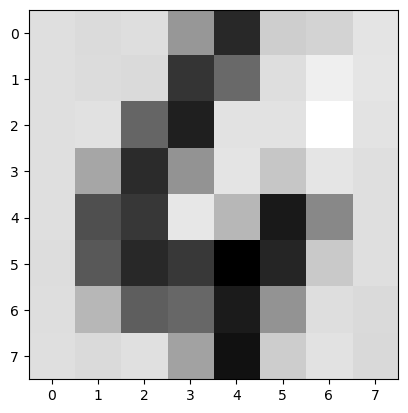

In [35]:
samples = gm.sample(100)
plt.imshow(pca.inverse_transform(samples[0][17]).reshape(8, 8), cmap='binary')

Визуализируйте полученные результаты. Введите номер изображения, соответствующего сгенерированному объекту с индексом $5$ (индексация начинается с нуля)